In [1]:
using Plots, Printf, DelimitedFiles, DelimitedFiles, Serialization, Random
using BSON: @load
include("../src/MDToolbox.jl")
using .MDToolbox

In [2]:
SEED_NUM = 1
SIGMA = 7
FRAME_NUM = 1000
TRANSITION_NUM = 5
RADIUS = 20

q_array = readdlm("data/quaternion/QUATERNION_LIST_576_Orient")
model_array = readpdb("data/t1r/cluster.pdb");
for iatom = 1:model_array.natom
    model_array.atomname[iatom] = model_array.resname[iatom]
end
MDToolbox.decenter!(model_array)
param_array = [AfmizeConfig(10.0 * (pi / 180),
                            r, 
                            MDToolbox.Point2D(-200, -200), 
                            MDToolbox.Point2D(200, 200), 
                            MDToolbox.Point2D(6.25, 6.25), 
                            MDToolbox.defaultParameters())
                            for r in [RADIUS]]

model_num = size(model_array, 1)
q_num = size(q_array, 1)

576

In [3]:
function quate_dist(q1, q2)
    # return min(sum(q1 .+ q2) .^ 2, sum(q1 .- q2) .^ 2)
    acos(max(-1, min(1, 2.0 * sum(q1.*q2).^2 - 1.0)))
end

function rand_sample(p, seed)
  p_cum = cumsum(p) ./ sum(p)
  r = rand(seed)
  for i = 1:length(p_cum)
    if r <= p_cum[i]
      return i
    end
  end
end

function rand_generate(nframe::Int, T, pi_i, seed)
  states = zeros(typeof(nframe), nframe)

  states[1] = rand_sample(pi_i, seed)
  for iframe = 2:nframe
    states[iframe] = rand_sample(T[states[iframe-1], :], seed)
  end
  return states
end

function make_rand_data(seed_num, sigma, frame_num, radius, transitions_num)
    @load "data/t1r/t1r.bson" T pi_i p_all
    seed = MersenneTwister(seed_num)
    state_trans = rand_generate(frame_num, T, pi_i, seed)
    
    quate_T = zeros(Float64, q_num, q_num)
    for i in 1:q_num
        arr = []
        for j in 1:q_num
            push!(arr, (quate_dist(q_array[i, :], q_array[j, :]), j))
        end
        sort!(arr)
        for id in 1:transitions_num
            quate_T[i, arr[id][2]] = 1 / transitions_num
        end
    end
    pi_quate_i = ones(Float64, q_num) ./ q_num
    quate_trans = rand_generate(frame_num, quate_T, pi_quate_i, seed)
    
    ret = []
    dx = 0
    dy = 0
    for i in 1:frame_num
        model = deepcopy(model_array[state_trans[i], :])
        quate = q_array[quate_trans[i], :]
        dx = max(-40, min(40, dx + randn(seed) * 5))
        dy = max(-40, min(40, dy + randn(seed) * 5))
        model.x .+= dx
        model.y .+= dy
        config = AfmizeConfig(10.0 * (pi / 180), 
                              radius, 
                              MDToolbox.Point2D(-200, -200), 
                              MDToolbox.Point2D(200, 200), 
                              MDToolbox.Point2D(6.25, 6.25), 
                              MDToolbox.defaultParameters())
        model = MDToolbox.rotate(model, quate)
        afm = MDToolbox.afmize(model, config)
        # afm = zeros(Int64(div(config.range_max.y - config.range_min.y, config.resolution.y)), 
        #     Int64(div(config.range_max.x - config.range_min.x, config.resolution.x)))
        h, w = size(afm)
        afm .+= randn(seed, h, w) * sigma
        push!(ret, afm)
    end
    return ret, state_trans, quate_trans
end

make_rand_data (generic function with 1 method)

In [4]:
seed_nums = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
sigmas = [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7]
nums = [100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100, 100]
test_num = size(seed_nums, 1)

20

In [5]:
results_list = []
state_trans_list = []
quate_trans_list = []
for test_id in 1:test_num
    seed_num = seed_nums[test_id]
    sigma = sigmas[test_id]
    frame_num = nums[test_id]
    
    results = MDToolbox.inputResults("afm_rotate_test_seed_$(seed_num)_sigma_$(sigma)_frame_num_$(frame_num).txt", q_num);
    frames, state_trans, quate_trans = make_rand_data(seed_num, sigma, frame_num, RADIUS, TRANSITION_NUM);
    push!(results_list, results)
    push!(state_trans_list, state_trans)
    push!(quate_trans_list, quate_trans)
    """
    anim = @animate for i in 1:frame_num
        heatmap(frames[i])
    end
    gif(anim, "afm_rotate_test_seed_$(seed_num)_sigma_$(sigma)_frame_num_$(frame_num).gif", fps = 10)
    """
end

In [6]:
cou = 0
for test_id in 1:test_num
    result = results_list[test_id]
    state_trans = state_trans_list[test_id]
    quate_trans = quate_trans_list[test_id]
    for frame_id in 1:size(result, 1)
        cou += 1
        if cou % 100 == 0
            max_diff = 0
            quate_candication = -1
            for i in 1:q_num
                diff = quate_dist(q_array[result[frame_id].best_quate_id, :], q_array[i, :])
                if max_diff < diff
                    max_diff = diff
                    quate_candication = i
                end
            end
            tmp = result[frame_id].posterior_results[result[frame_id].best_model_id, result[frame_id].best_quate_id]
            result[frame_id].posterior_results[result[frame_id].best_model_id, result[frame_id].best_quate_id] = result[frame_id].posterior_results[result[frame_id].best_model_id, quate_candication]
            result[frame_id].posterior_results[result[frame_id].best_model_id, quate_candication] = tmp
            result[frame_id].best_quate_id = quate_candication
        end
    end
end

ok is 1966
ng is 34
rate is 0.983


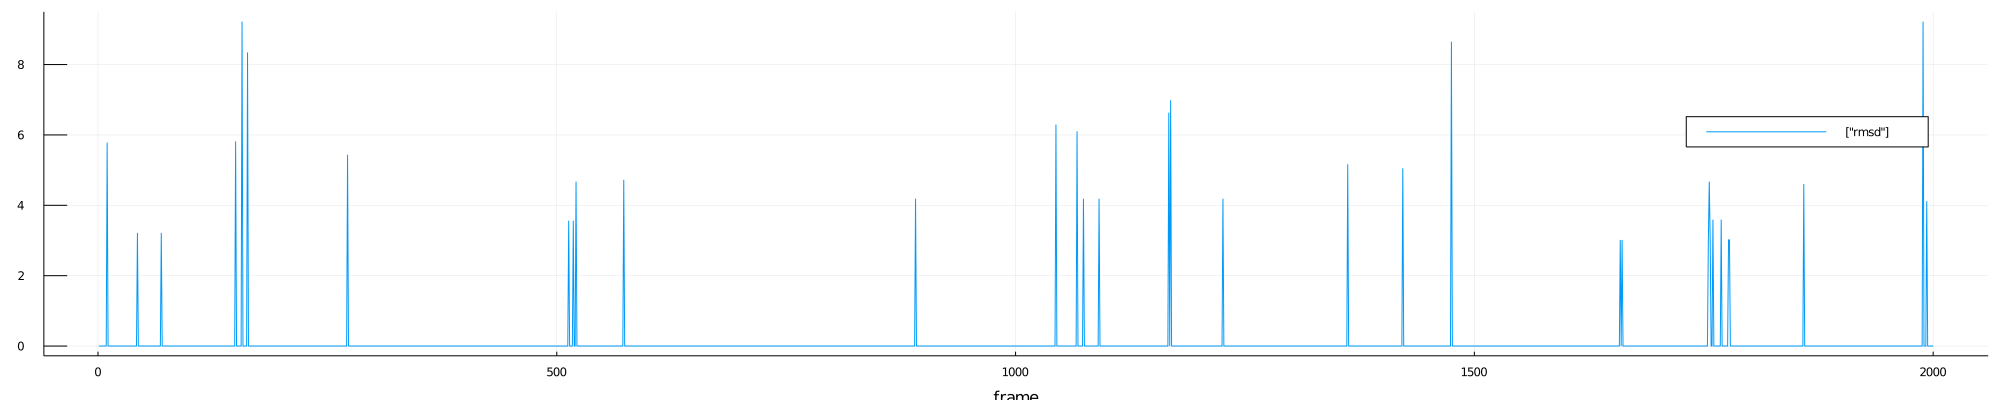

In [7]:
ok = 0
ng = 0
rmsds_default = []
quate_diff_default = []
for test_id in 1:test_num
    result = results_list[test_id]
    state_trans = state_trans_list[test_id]
    quate_trans = quate_trans_list[test_id]
    for frame_id in 1:size(result, 1)
        if result[frame_id].best_model_id == state_trans[frame_id]
            ok += 1
        else
            ng += 1
        end
        push!(rmsds_default, MDToolbox.compute_rmsd(model_array[result[frame_id].best_model_id, :], model_array[state_trans[frame_id], :])[1])
        push!(quate_diff_default, quate_dist(q_array[result[frame_id].best_quate_id, :], q_array[quate_trans[frame_id], :]))
    end
end

println("ok is $ok")
println("ng is $ng")
println("rate is $(ok / (ok + ng))")

plot(1:size(rmsds_default, 1), rmsds_default, label = ["rmsd"], size=(2000, 400))
xlabel!("frame")
ylabel!("rmsd")

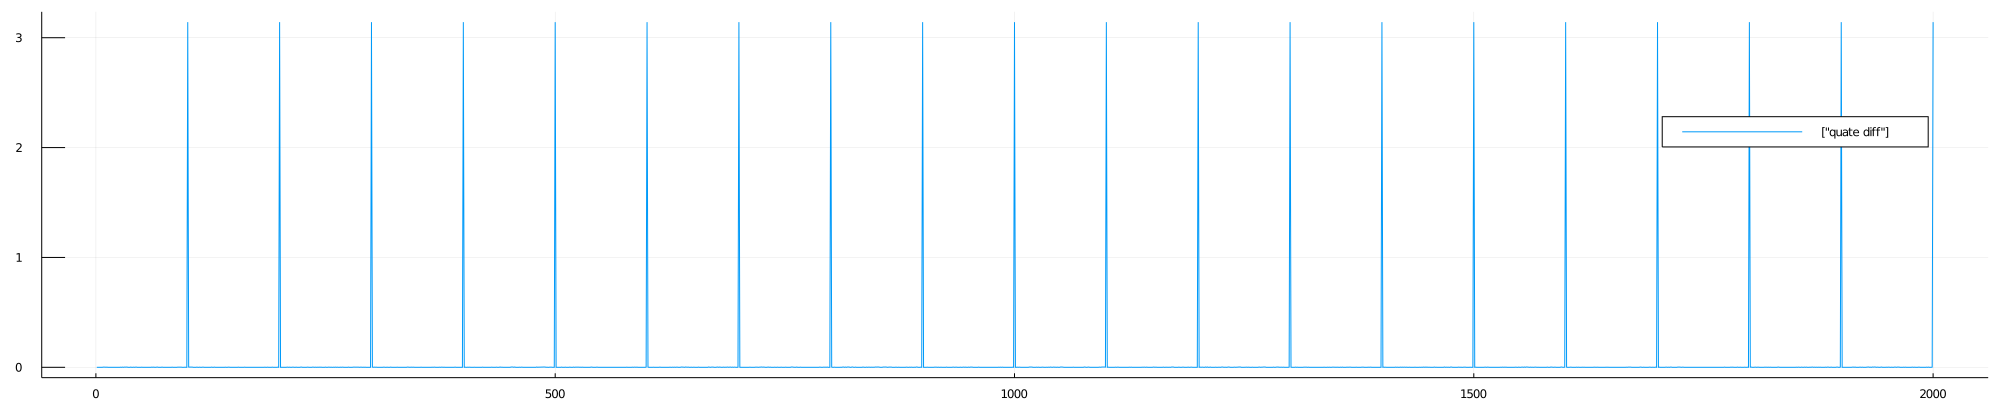

In [8]:
plot(1:size(quate_diff_default, 1), quate_diff_default, label = ["quate diff"], size=(2000, 400))

test id is: 1
id size: 94
test id is: 2
id size: 98
test id is: 3
id size: 100
test id is: 4
id size: 90
test id is: 5
id size: 98
test id is: 6
id size: 96
test id is: 7
id size: 91
test id is: 8
id size: 95
test id is: 9
id size: 94
test id is: 10
id size: 97
test id is: 11
id size: 100
test id is: 12
id size: 102
test id is: 13
id size: 96
test id is: 14
id size: 90
test id is: 15
id size: 96
test id is: 16
id size: 94
test id is: 17
id size: 86
test id is: 18
id size: 90
test id is: 19
id size: 100
test id is: 20
id size: 99
ok is 1947
ng is 53
rate is 0.9735


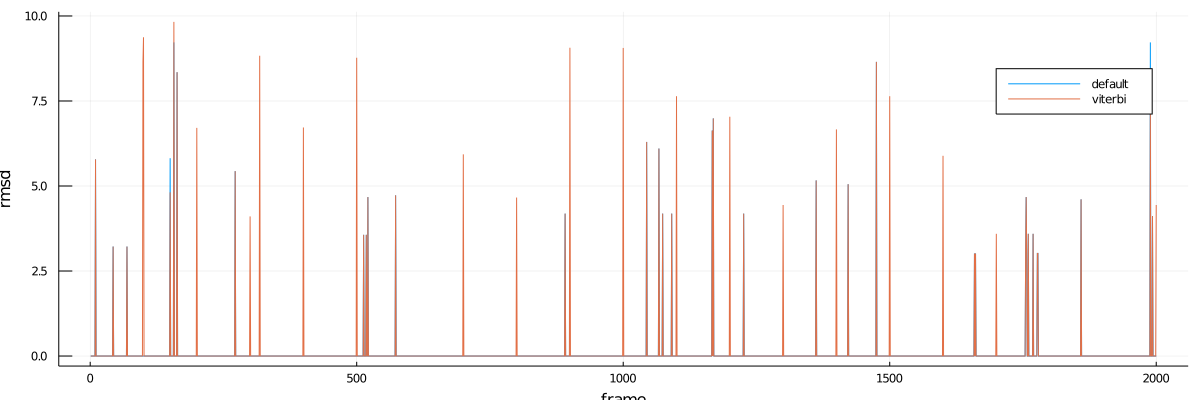

In [18]:
ok = 0
ng = 0
rmsds = []
quate_diff = []
for test_id in 1:test_num
    println("test id is: $(test_id)")
    @load "data/t1r/t1r.bson" T pi_i p_all
    result = results_list[test_id]
    state_trans = state_trans_list[test_id]
    quate_trans = quate_trans_list[test_id]
    frame_num = size(result, 1)
    
    max_prob = zeros(model_num, q_num)
    for frame_id in 1:size(result, 1)
        max_prob = max.(max_prob, result[frame_id].posterior_results)
    end
    
    id = findall(max_prob .> 1e-10)
    max_prob[id]
    id_size = size(id, 1)
    
    println("id size: $(id_size)")
    
    quate_T = zeros(Float64, q_num, q_num)
    for i in 1:q_num
        arr = []
        for j in 1:q_num
            push!(arr, (quate_dist(q_array[i, :], q_array[j, :]), j))
        end
        sort!(arr)
        for id in 1:TRANSITION_NUM
            quate_T[i, arr[id][2]] = 1
        end
    end

    tmp_T = zeros(id_size, id_size)
    for i in 1:id_size
        for j in 1:id_size
            if quate_T[id[i][2], id[j][2]] != 1
                continue
            end
            tmp_T[i, j] = T[id[i][1], id[j][1]] / TRANSITION_NUM
        end
    end

    emission = zeros(Float64, id_size, frame_num)
    for frame_id in 1:frame_num
        for i in 1:id_size
            emission[i, frame_id] = result[frame_id].posterior_results[id[i]] + 1e-3
        end
    end
    
    tmp_pi_i = ones(id_size) ./ id_size
    
    state_estimated_id = msmviterbi(collect(1:frame_num), tmp_T, tmp_pi_i, emission)
    
    state_estimated = []
    quate_estimated = []
    for frame_id in 1:frame_num
        push!(state_estimated, id[state_estimated_id[frame_id]][1])
        push!(quate_estimated, id[state_estimated_id[frame_id]][2])
    end
    state_estimated
    
    for frame_id in 1:size(result, 1)
        if state_estimated[frame_id] == state_trans[frame_id]
            ok += 1
        else
            ng += 1
        end
        push!(rmsds, MDToolbox.compute_rmsd(model_array[state_estimated[frame_id], :], model_array[state_trans[frame_id], :])[1])
        push!(quate_diff, quate_dist(q_array[quate_estimated[frame_id], :], q_array[quate_trans[frame_id], :]))
    end
end

println("ok is $ok")
println("ng is $ng")
println("rate is $(ok / (ok + ng))")

plot(1:size(rmsds_default, 1), [rmsds_default, rmsds], label = ["default" "viterbi"], size=(1200, 400))
xlabel!("frame")
ylabel!("rmsd")

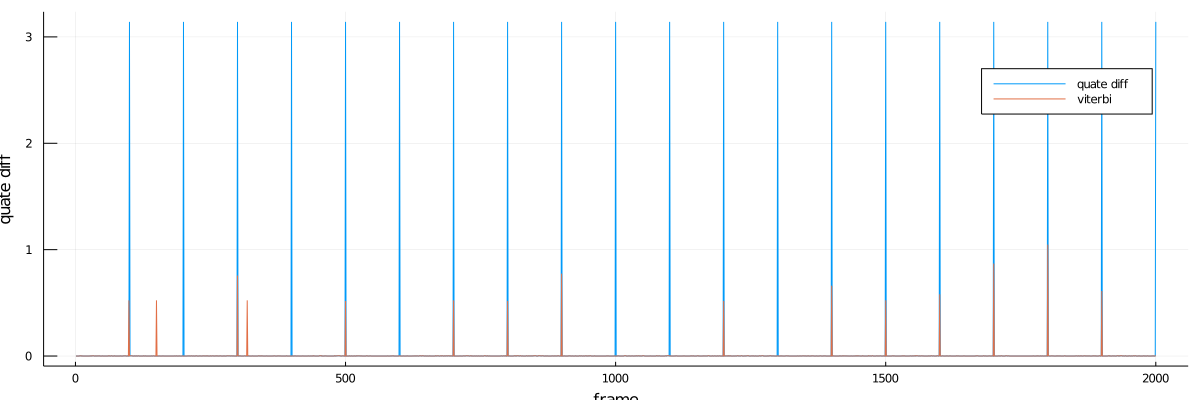

In [19]:
plot(1:size(quate_diff_default, 1), [quate_diff_default, quate_diff], label = ["quate diff" "viterbi"], size=(1200, 400))
xlabel!("frame")
ylabel!("quate diff")